In [1]:
"""
LT 7/15/24 - Porting all kedar here, about activity aligned to fixation events.

"""

'\nLT 7/15/24 - Porting all kedar here, about activity aligned to fixation events.\n\n'

In [2]:
from neuralmonkey.classes.population_mult import load_handsaved_wrapper, dfpa_match_chans_across_pa_each_bregion
from neuralmonkey.classes.population_mult import extract_single_pa
import os
import pandas as pd
%load_ext autoreload
%autoreload 2

Keep, for  M1_m  ... 24 / 26
Keep, for  M1_l  ... 19 / 21
Keep, for  PMv_m  ... 20 / 21
Keep, for  PMd_p  ... 36 / 39
Keep, for  PMd_a  ... 22 / 22
Keep, for  dlPFC_p  ... 8 / 8
Keep, for  dlPFC_a  ... 9 / 9
Keep, for  vlPFC_p  ... 18 / 18
Keep, for  vlPFC_a  ... 8 / 8
Keep, for  FP_p  ... 7 / 7
Keep, for  FP_a  ... 6 / 6
Keep, for  SMA_p  ... 23 / 23
Keep, for  SMA_a  ... 16 / 16
Keep, for  preSMA_p  ... 23 / 23
Keep, for  preSMA_a  ... 13 / 13


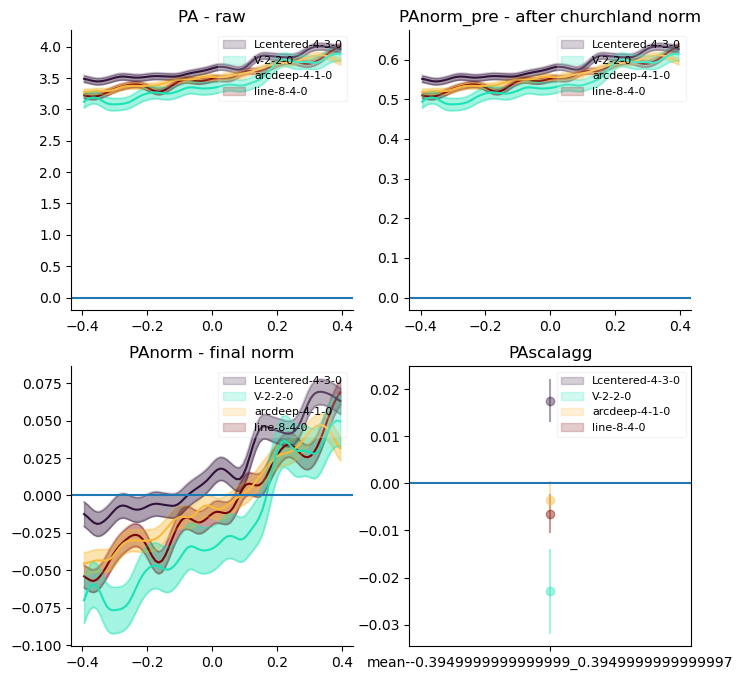

In [3]:
# Method 1 - load a single DFallPA


animal = "Pancho"
date = 230626

# animal = "Diego"
# date = 240625

which_level = "saccade_fix_on"
combine_areas = False
DFallpa = load_handsaved_wrapper(animal=animal, date=date, version=which_level, combine_areas=combine_areas, use_time=True)


### PREPROCESS
from neuralmonkey.classes.population_mult import dfpa_concatbregion_preprocess_clean_bad_channels
dfpa_concatbregion_preprocess_clean_bad_channels(DFallpa, PLOT=False)

for pa in DFallpa["pa"]:
    pa.X = pa.X**0.5

from neuralmonkey.classes.population_mult import dfallpa_preprocess_fr_normalization
# fr_normalization_method = "each_time_bin"
fr_normalization_method = "across_time_bins"
plot_savedir = "/tmp"
dfallpa_preprocess_fr_normalization(DFallpa, fr_normalization_method, plot_savedir)    

In [ ]:
# Method 2 - Combine two dfallpa
animal = "Diego"
date = 230630
COMBINE_AREAS = True

# animal = "Pancho"
# date = 230626
# COMBINE_AREAS = False

DFallpa1 = load_handsaved_wrapper(animal=animal, date=date, version="trial", combine_areas=COMBINE_AREAS, use_time=True)

which_level = "saccade_fix_on"
DFallpa2 = load_handsaved_wrapper(animal=animal, date=date, version=which_level, combine_areas=COMBINE_AREAS, use_time=True)

# DFallpa2 = load_handsaved_wrapper(animal=animal, date=date, version="stroke", combine_areas=COMBINE_AREAS, use_time=True)

DFallpa = pd.concat([DFallpa1, DFallpa2]).reset_index(drop=True)

from neuralmonkey.classes.population_mult import dfpa_concatbregion_preprocess_wrapper
fr_normalization_method = "across_time_bins"
dfpa_concatbregion_preprocess_wrapper(DFallpa, fr_mean_subtract_method=fr_normalization_method)

In [4]:
# Add variables
def f(smi):
    if smi == -1:
        return "withinfixation"
    elif smi in [0,1]:
        return "early"
    elif smi>1:
        return "late"
    else:
        assert False
for pa in DFallpa["pa"]:
    dflab = pa.Xlabels["trials"]
    if "shape-macrosaccade-index" in dflab.columns:
        dflab["early_late_by_smi"] = [f(smi) for smi in dflab["shape-macrosaccade-index"]]


# Sanity check - extracted fixations

In [ ]:
sorted(dflab.columns)

In [ ]:
pa = DFallpa["pa"].values[0]
dflab = pa.Xlabels["trials"]

tc = sorted(dflab["trialcode"].unique())[0]

tc = "230626-2-151"

dfthis = dflab[dflab["trialcode"] == tc]

print(tc)
dfthis.loc[:, ["shape-fixation", "event_time", "event_idx_within_trial", "first-fixation-on-shape", "shape-macrosaccade-index"]]

In [ ]:
# NOTE: Confirmed that fixations are correct, relative to what I plotted in timecourse.

# State space plots (shape-fixation vs. seqc_0_shape)

In [ ]:
SAVEDIR_ANALYSIS = f"/lemur2/lucas/analyses/recordings/main/eyetracking_analyses/SUBSPACES/{animal}-{date}"
os.makedirs(SAVEDIR_ANALYSIS, exist_ok=True)


### Plot scalar values (time-mean within twindow)

In [ ]:
DFallpa = DFallpa[DFallpa["bregion"] == "PMv_m"].reset_index(drop=True)

In [ ]:
pa = DFallpa["pa"].values[0]
dflab = pa.Xlabels["trials"]
from pythonlib.tools.pandastools import grouping_print_n_samples, append_col_with_grp_index
grouping_print_n_samples(dflab, ["between-stimonset-and-go", "early-or-late-planning-period", "is-first-macrosaccade", "shape-macrosaccade-index", "event_idx_within_trial", "first-fixation-on-shape"])

In [ ]:
pa = DFallpa["pa"].values[0]
pa.Xlabels["trials"]["seqc_0_shape"].value_counts()


In [ ]:
shapes_keep = [sh for sh in dflabthis["seqc_0_shape"].unique() if len(dflabthis[dflabthis["seqc_0_shape"]==sh]["trialcode"].unique())>n_min]


In [ ]:
from neuralmonkey.scripts.analy_eyefixation_PCA_statespace import plot_all

plot_all(DFallpa, SAVEDIR_ANALYSIS)

In [ ]:
dflab = pa.Xlabels["trials"]
dflab["event_time"]

In [ ]:
sorted(dflab.columns)

# Decode (generalize from draw to visual)

In [ ]:
# Categorical decoder.

In [ ]:
# NOTE: this doesnt do that well --> Reason: there is strong bias to predict the shape that is being controleld (seqc_0_shape).

In [5]:
## Cross-temporal decoder, trained on seqc_0_shape, tested on shape-fixation
from neuralmonkey.analyses.decode_good import decodewrapouterloop_categorical_cross_time_cross_var, decodewrapouterloop_categorical_cross_time_plot

SAVEDIR_ANALYSIS = f"/lemur2/lucas/analyses/recordings/main/eyetracking_analyses/DECODERS/{animal}-{date}"
SAVEDIR_ANALYSIS = f"/tmp/{animal}-{date}"

SAVEDIR = f"{SAVEDIR_ANALYSIS}/cross_temporal_diff_var_train_test"
os.makedirs(SAVEDIR, exist_ok=True)


In [6]:
filtdict_train = {
    "FEAT_num_strokes_beh":[1],
    "FEAT_num_strokes_task":[1],
}


In [7]:
DFallpa

which_level              event   bregion        twind  \
0         flex  fixon_preparation      M1_m  (-0.4, 0.4)   
1         flex  fixon_preparation      M1_l  (-0.4, 0.4)   
2         flex  fixon_preparation     PMv_m  (-0.4, 0.4)   
3         flex  fixon_preparation     PMd_p  (-0.4, 0.4)   
4         flex  fixon_preparation     PMd_a  (-0.4, 0.4)   
5         flex  fixon_preparation   dlPFC_p  (-0.4, 0.4)   
6         flex  fixon_preparation   dlPFC_a  (-0.4, 0.4)   
7         flex  fixon_preparation   vlPFC_p  (-0.4, 0.4)   
8         flex  fixon_preparation   vlPFC_a  (-0.4, 0.4)   
9         flex  fixon_preparation      FP_p  (-0.4, 0.4)   
10        flex  fixon_preparation      FP_a  (-0.4, 0.4)   
11        flex  fixon_preparation     SMA_p  (-0.4, 0.4)   
12        flex  fixon_preparation     SMA_a  (-0.4, 0.4)   
13        flex  fixon_preparation  preSMA_p  (-0.4, 0.4)   
14        flex  fixon_preparation  preSMA_a  (-0.4, 0.4)   

                                                   pa      pa_x_shape  
0   <neuralmonkey.classes.population.PopAnal objec...  (26, 5210, 80)  
1   <neuralmonkey.classes.population.PopAnal objec...  (21, 5210, 80)  
2   <neuralmonkey.classes.population.PopAnal objec...  (21, 5210, 80)  
3   <neuralmonkey.classes.population.PopAnal objec...  (39, 5210, 80)  
4   <neuralmonkey.classes.population.PopAnal objec...  (22, 5210, 80)  
5   <neuralmonkey.classes.population.PopAnal objec...   (8, 5210, 80)  
6   <neuralmonkey.classes.population.PopAnal objec...   (9, 5210, 80)  
7   <neuralmonkey.classes.population.PopAnal objec...  (18, 5210, 80)  
8   <neuralmonkey.classes.population.PopAnal objec...   (8, 5210, 80)  
9   <neuralmonkey.classes.population.PopAnal objec...   (7, 5210, 80)  
10  <neuralmonkey.classes.population.PopAnal objec...   (6, 5210, 80)  
11  <neuralmonkey.classes.population.PopAnal objec...  (23, 5210, 80)  
12  <neuralmonkey.classes.population.PopAnal objec...  (16, 5210, 80)  
13  <neuralmonkey.classes.population.PopAnal objec...  (23, 5210, 80)  
14  <neuralmonkey.classes.population.PopAnal objec...  (13, 5210, 80)

In [8]:
filtdict_train = {}

In [9]:
filtdict_train

{}

In [10]:
filtdict_test = {"shape-macrosaccade-index":[1]}
# grouping_print_n_samples(dflab, ["between-stimonset-and-go", "early-or-late-planning-period", "is-first-macrosaccade", "shape-macrosaccade-index", "event_idx_within_trial", "first-fixation-on-shape"])

M1_m (-0.4, 0.4) fixon_preparation fixon_preparation
... Running decode for TRAIN: (grp, taskkind, n) ('Lcentered-4-3-0',) prims_on_grid n= (24, 1205, 80)  -- TEST: ('Lcentered-4-3-0',) prims_on_grid n= (24, 212, 80)
--- [filter_by_min_n], checking var= seqc_0_shape
level arcdeep-4-1-0, keeping, n=224
level Lcentered-4-3-0, keeping, n=722
level line-8-4-0, keeping, n=220
level V-2-2-0, keeping, n=39
(removing this many indices):  0
--- [filter_by_min_n], checking var= shape-fixation
level Lcentered-4-3-0, keeping, n=120
level line-8-4-0, keeping, n=31
level V-2-2-0, keeping, n=38
level arcdeep-4-1-0, keeping, n=23
(removing this many indices):  0
['var_decode', "('Lcentered-4-3-0',) : 722", "('V-2-2-0',) : 39", "('arcdeep-4-1-0',) : 224", "('line-8-4-0',) : 220"]
Saved to:  /tmp/Pancho-230626/cross_temporal_diff_var_train_test/M1_m-(-0.4, 0.4)-evtrain=fixon_preparation-evtest=fixon_preparation-tktrain=prims_on_grid-tktest=prims_on_grid-vartrain=seqc_0_shape-vartest=shape-fixation-TRAIN

KeyboardInterrupt: 

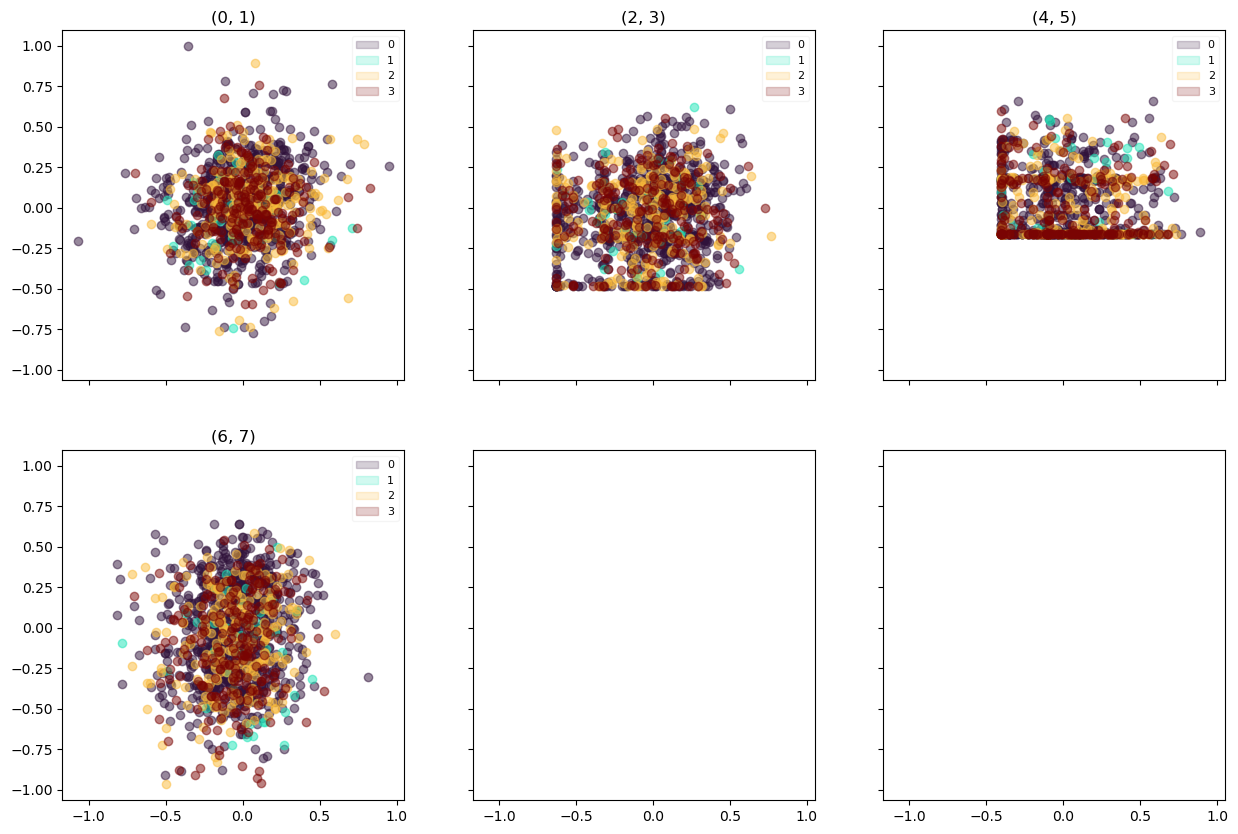

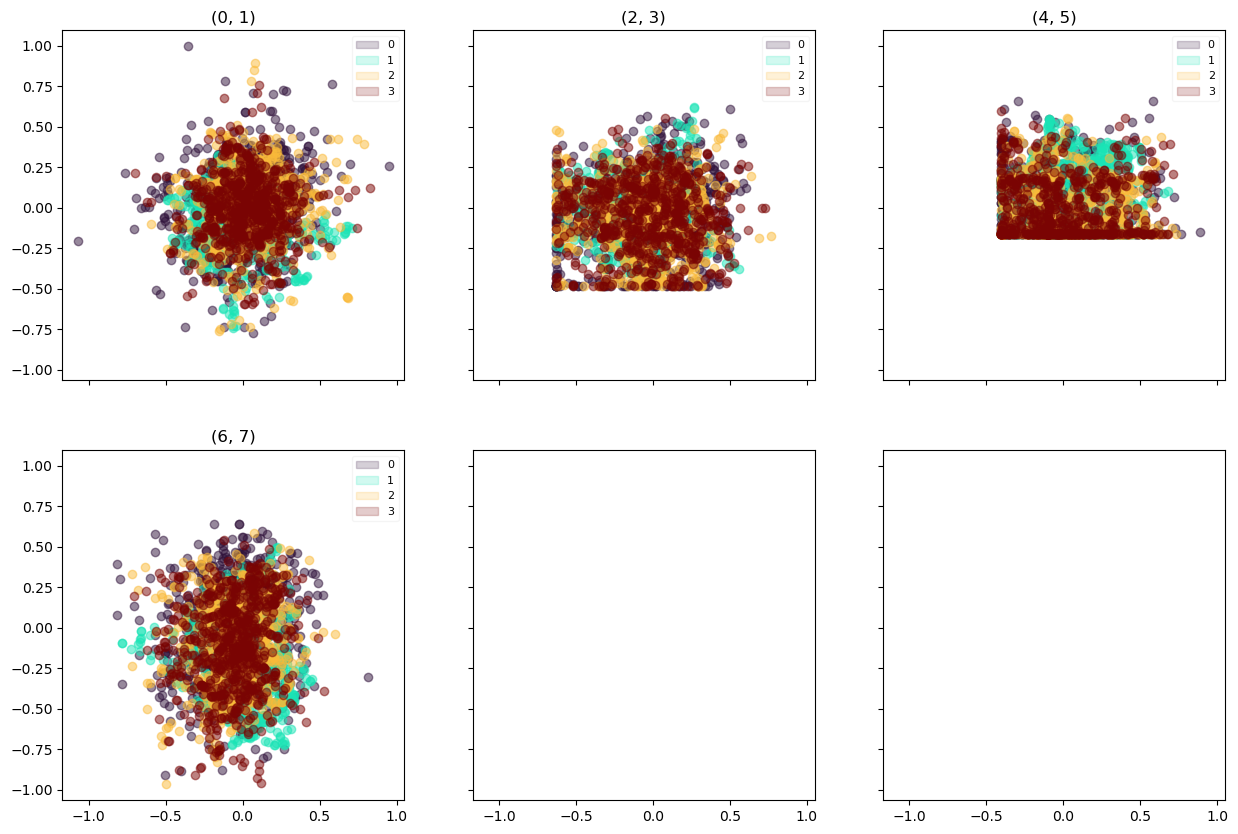

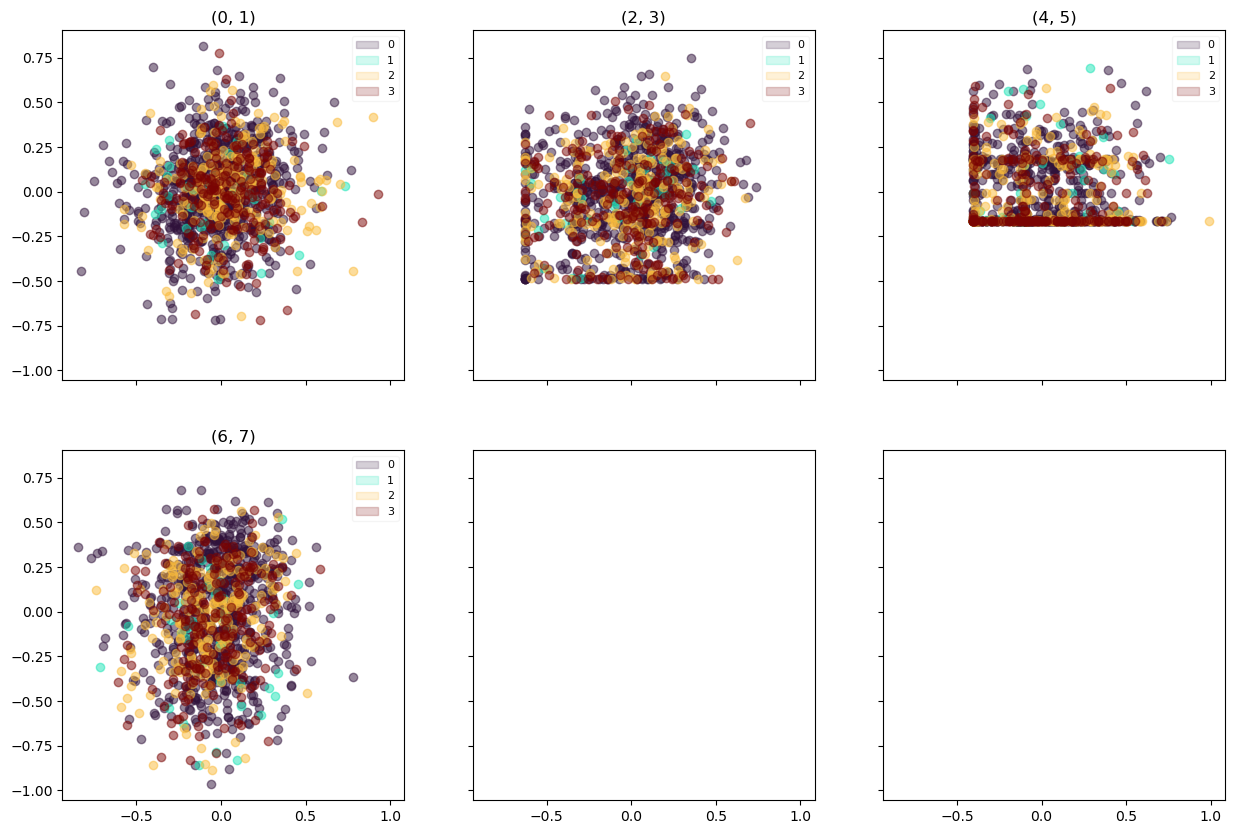

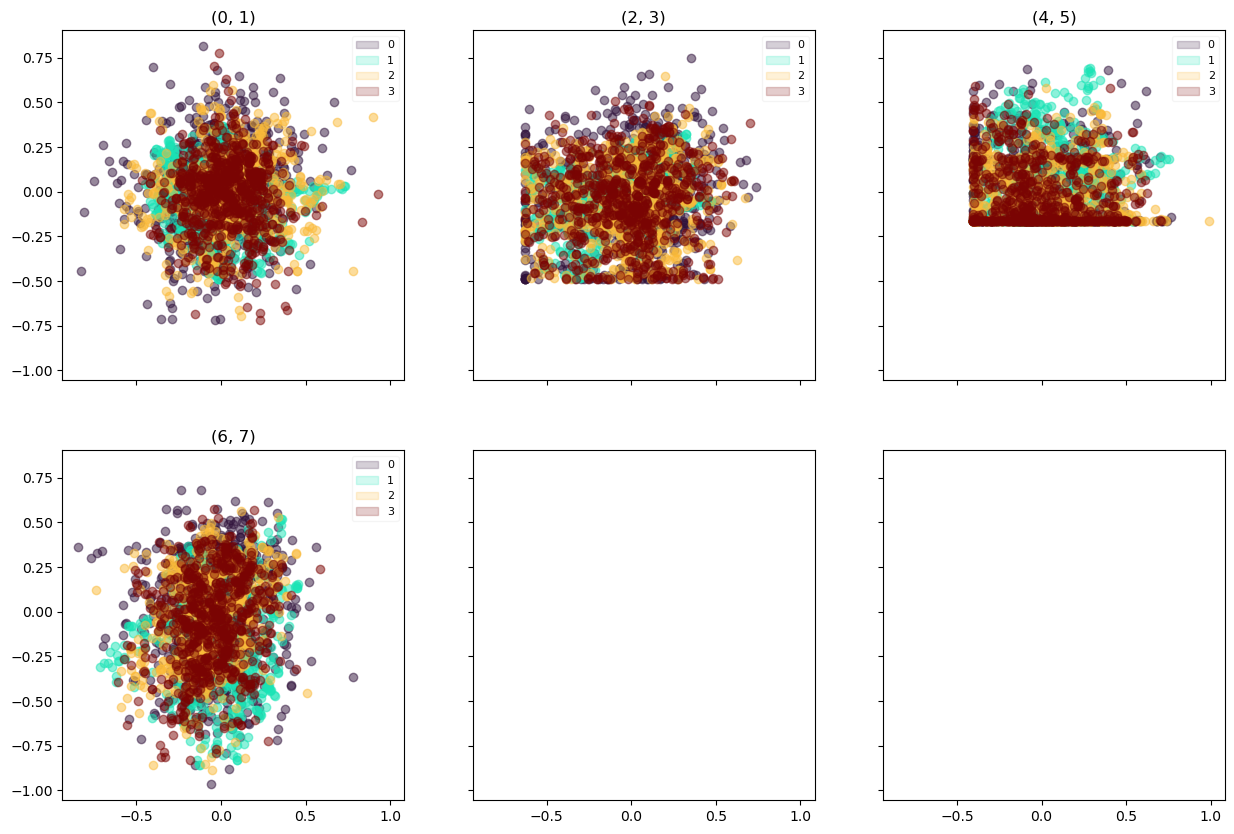

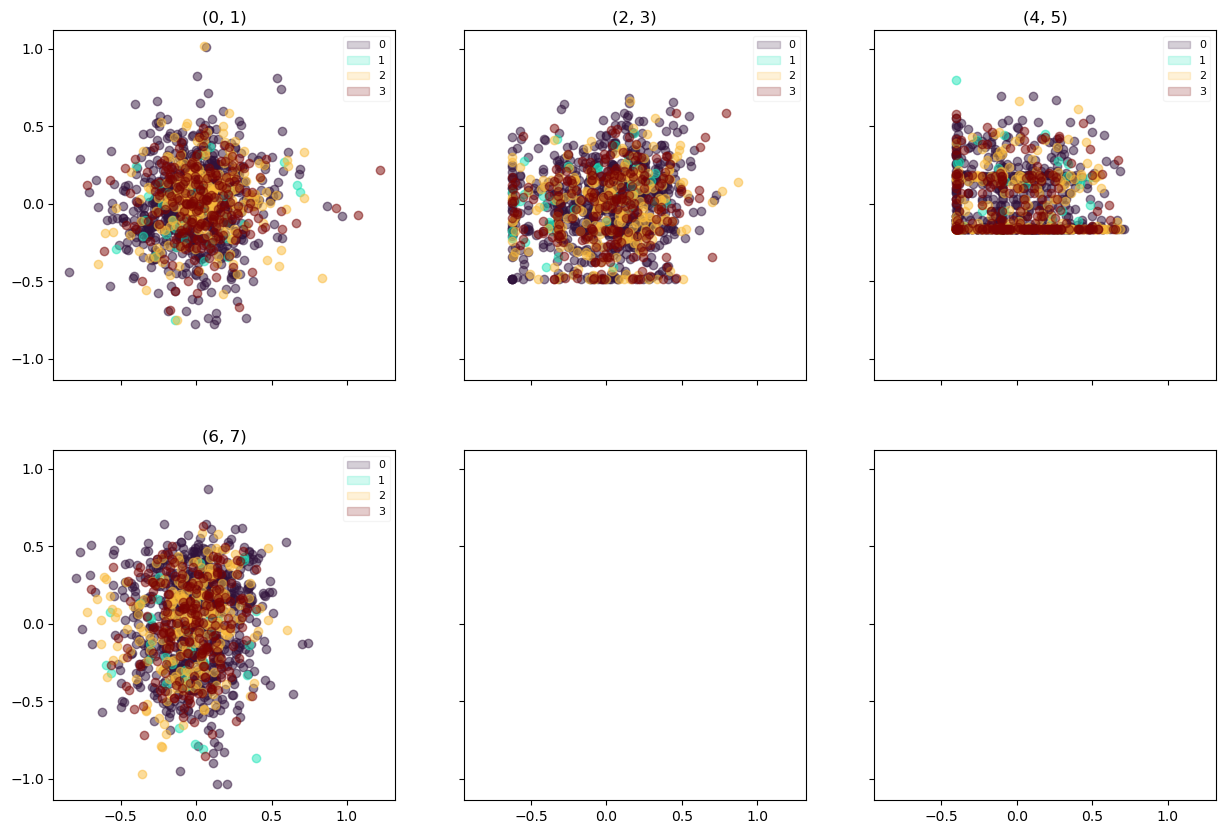

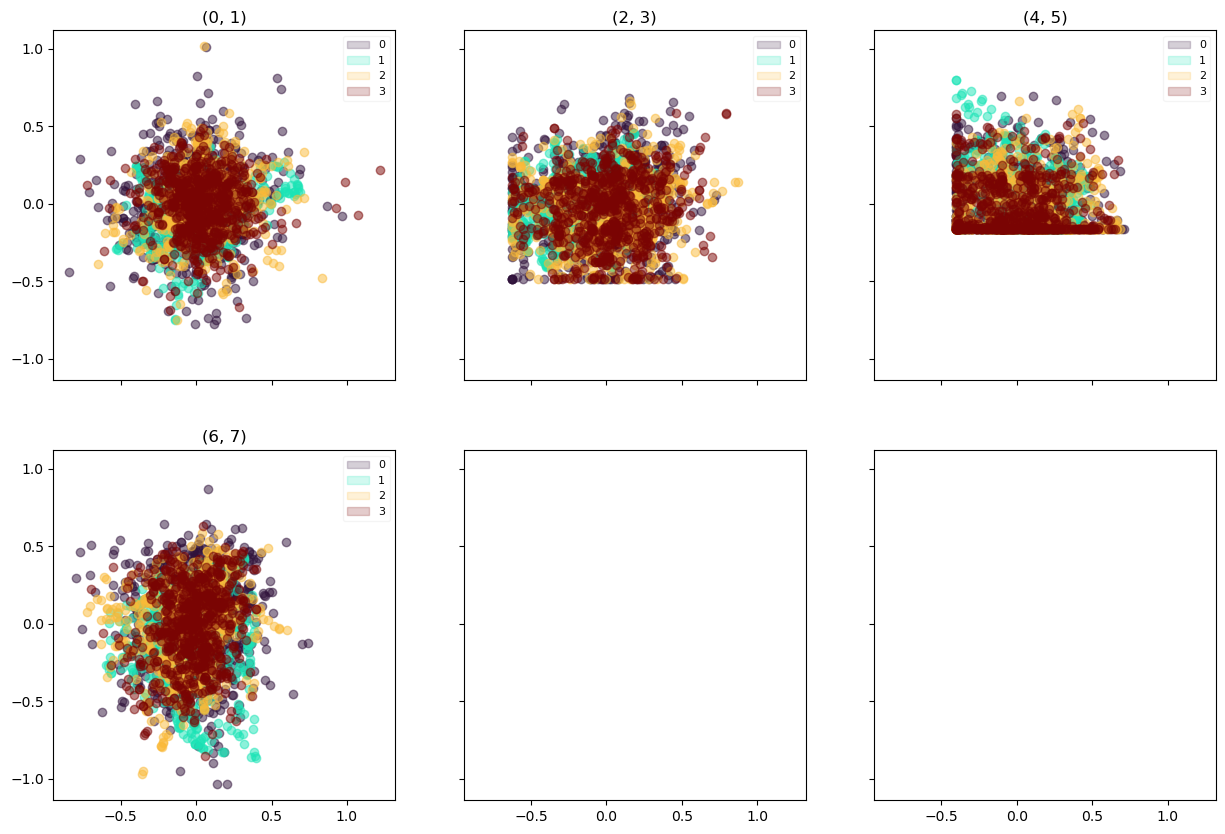

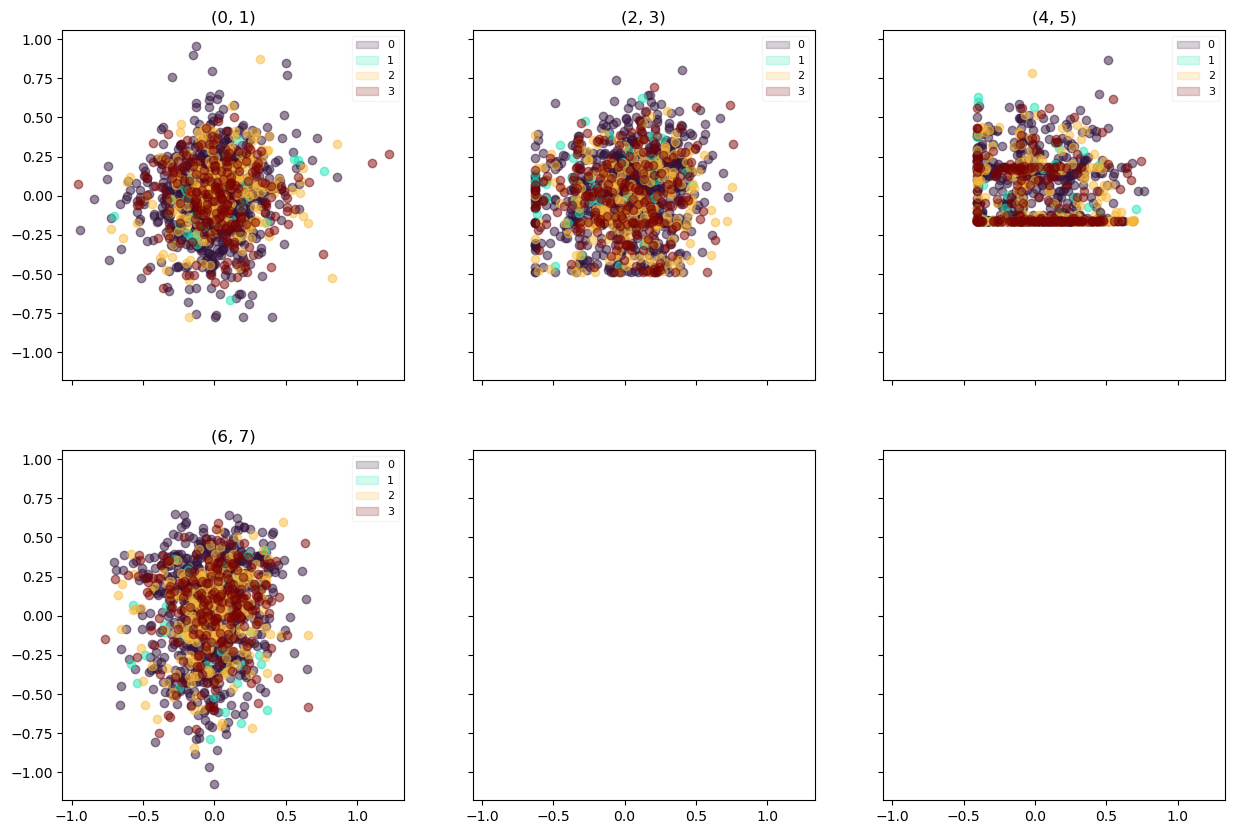

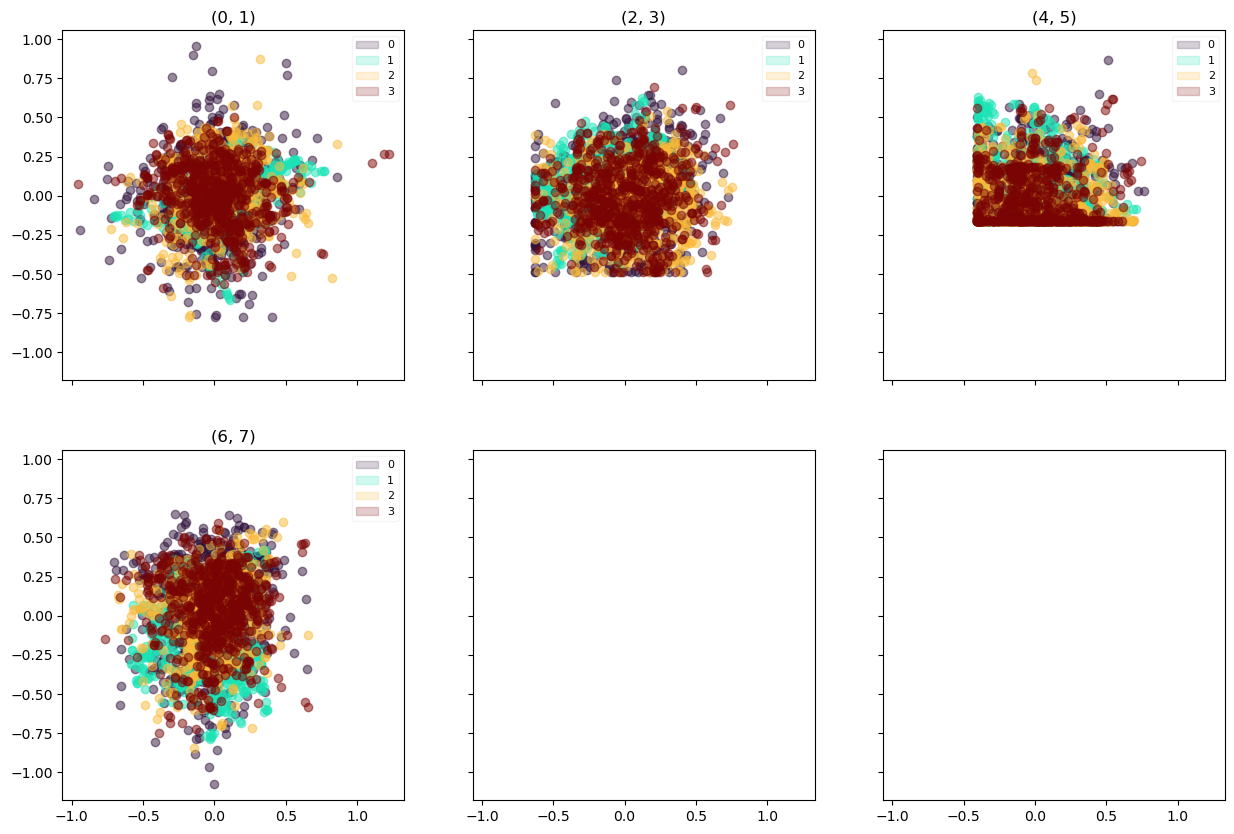

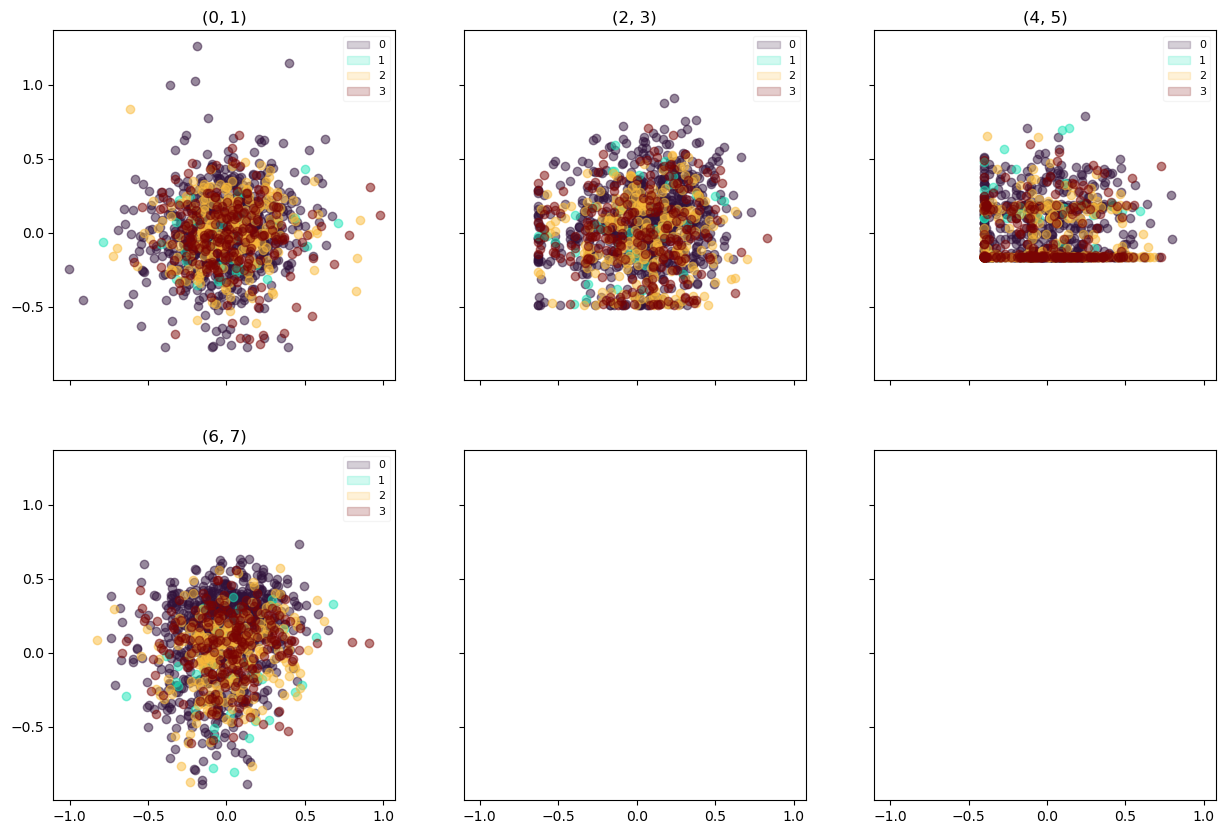

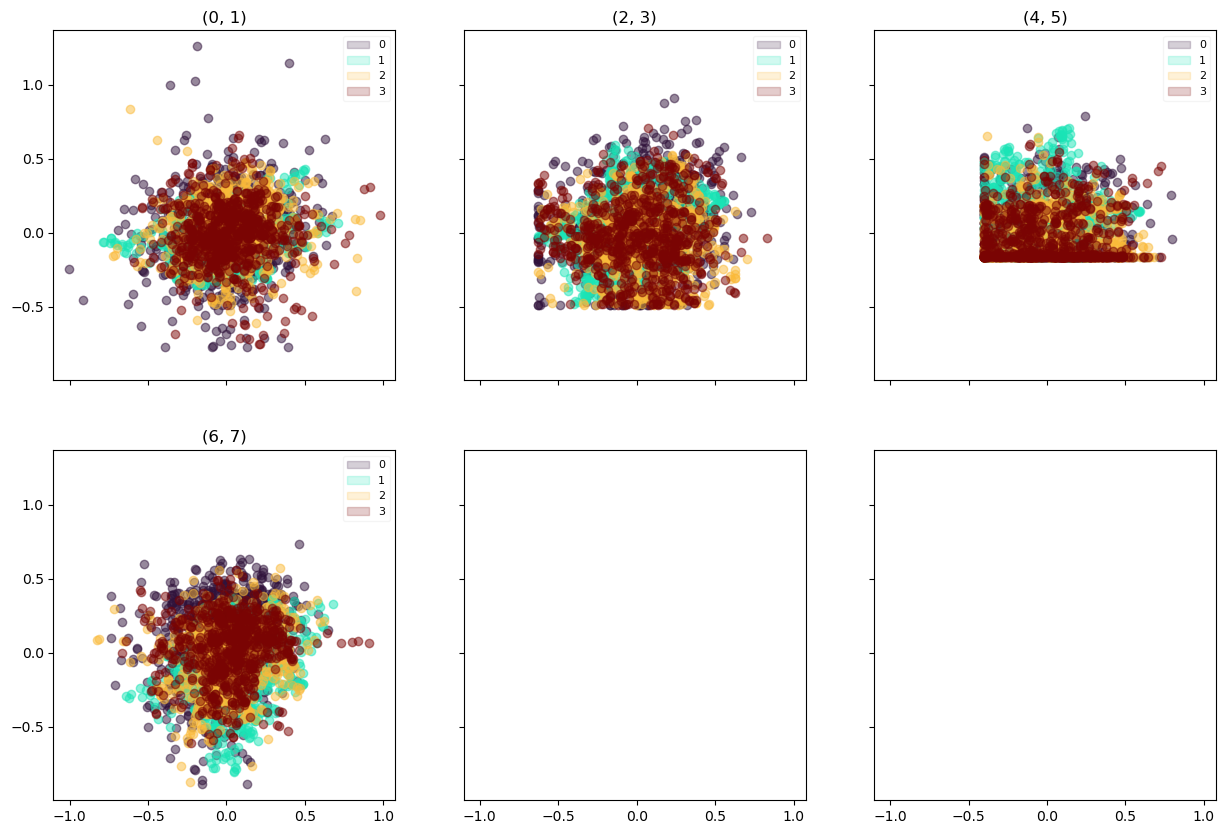

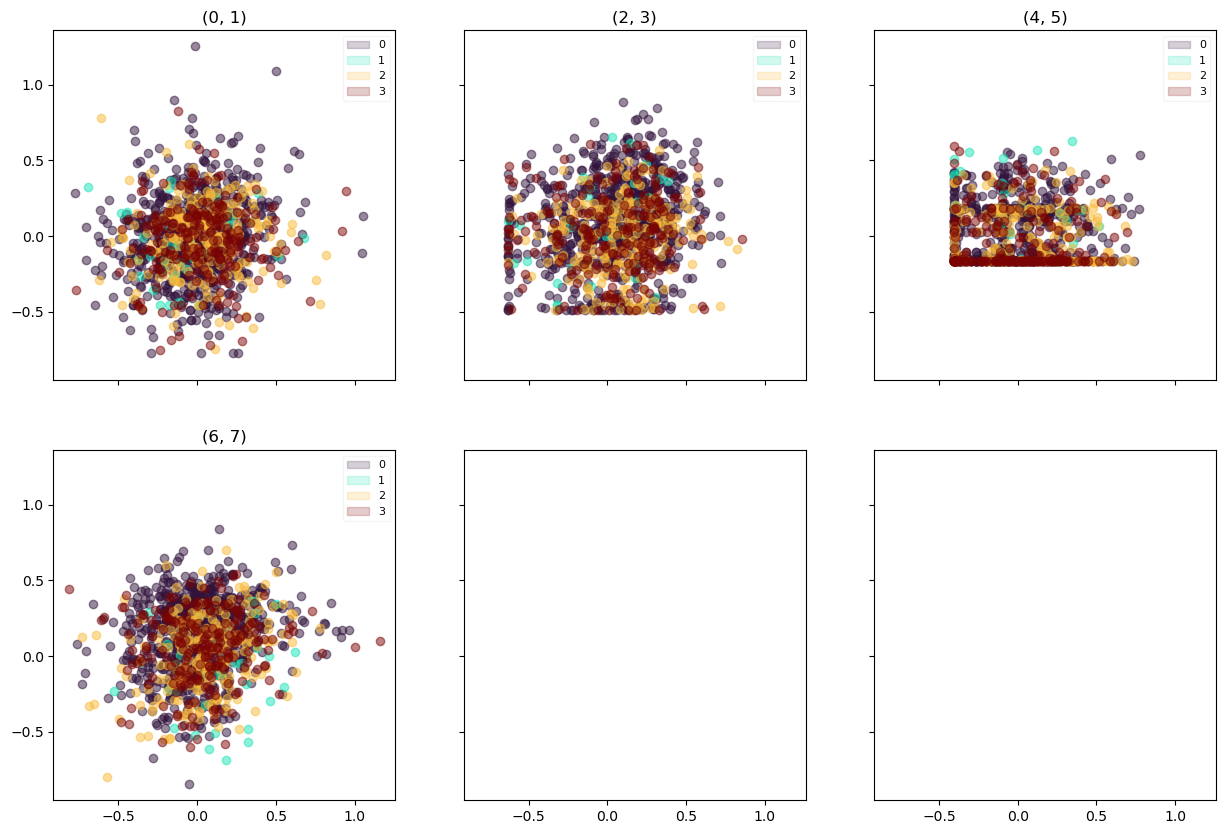

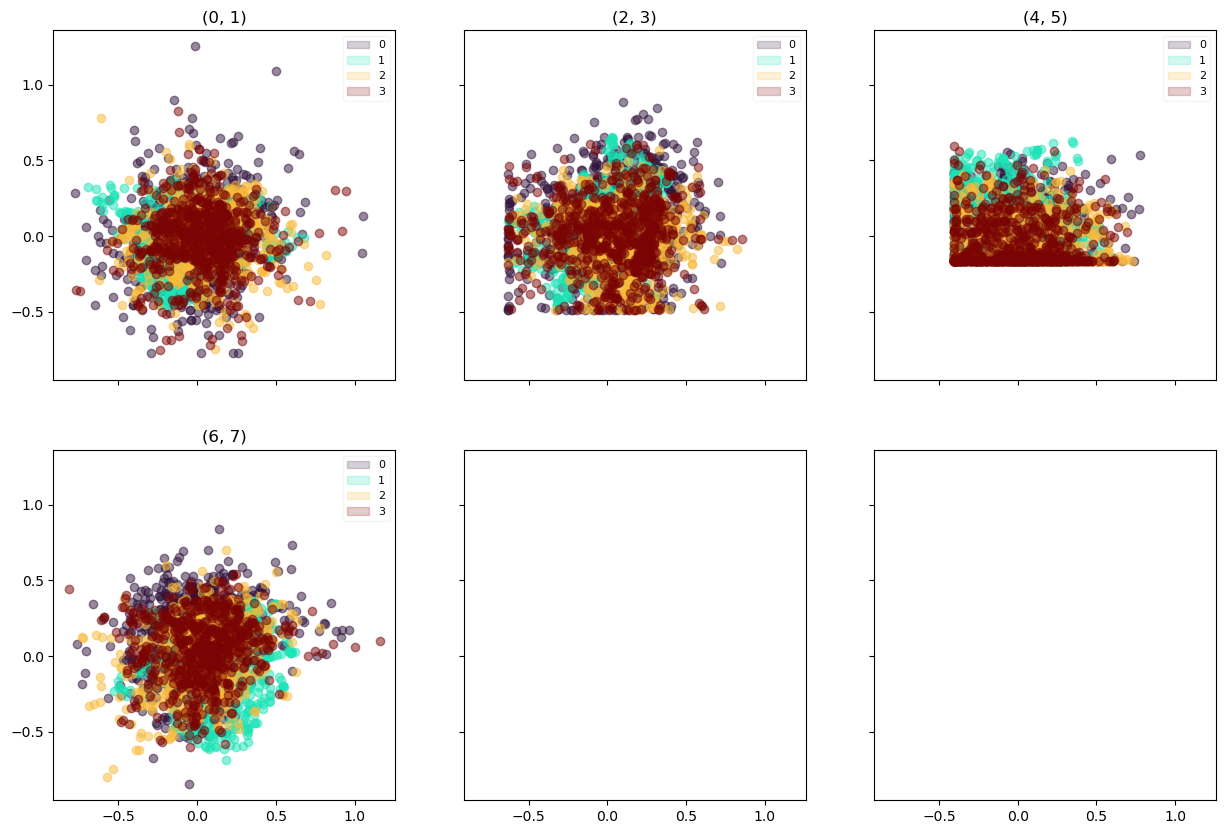

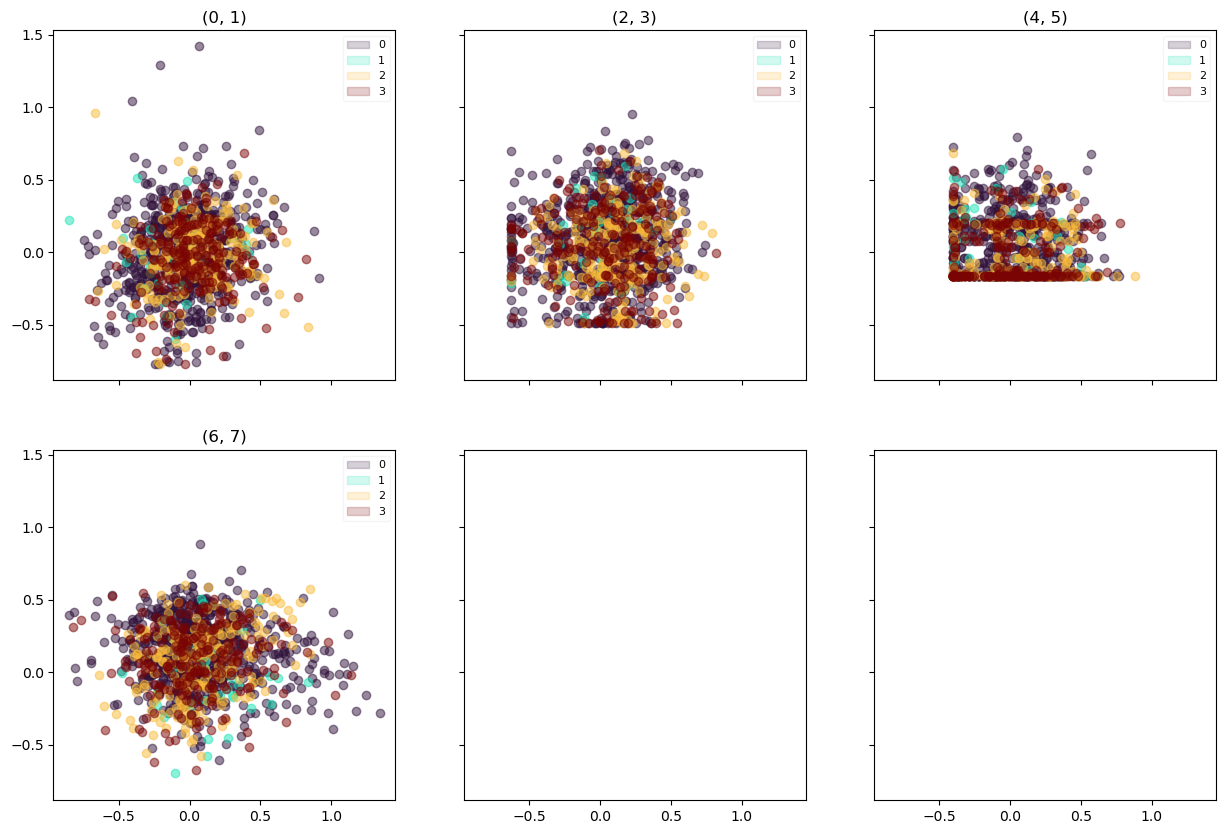

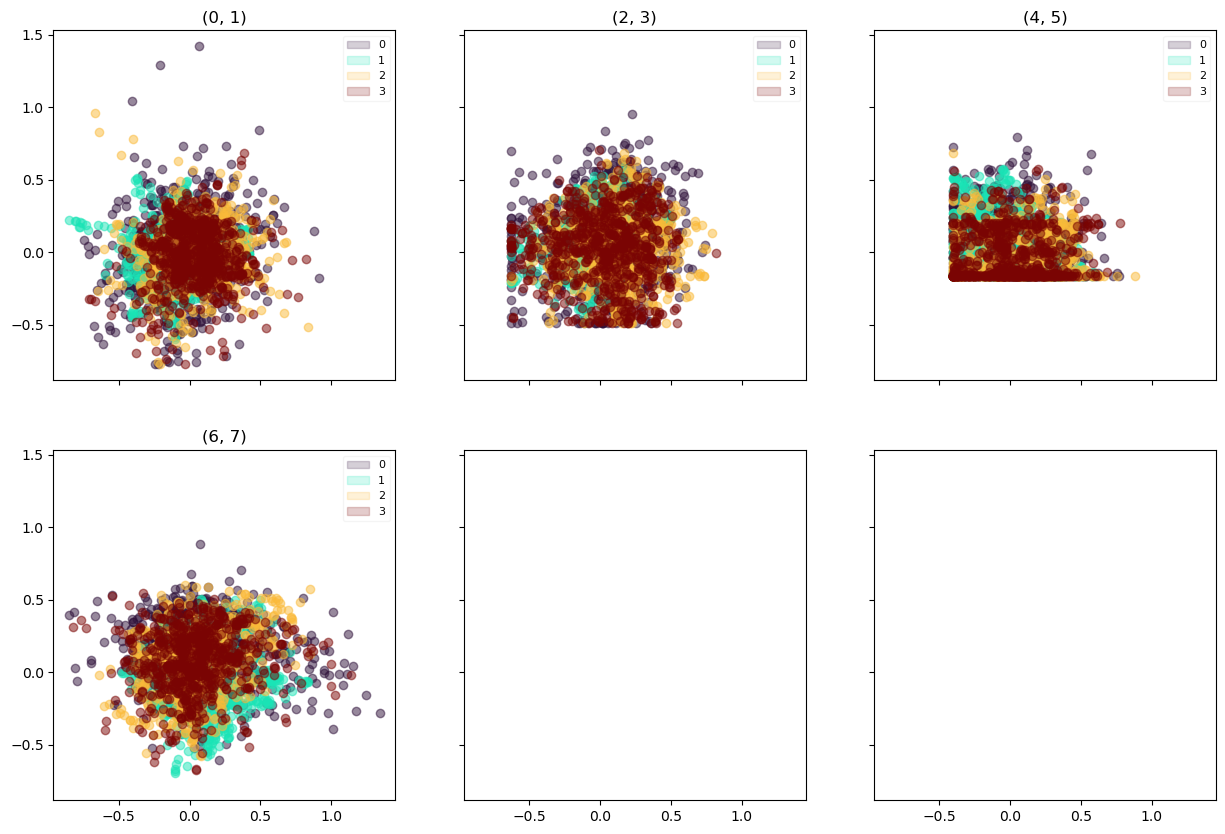

In [13]:

# time_bin_size = 0.1
# slide=0.02

time_bin_size = 0.2
slide=0.1

list_var_decode_train_test = [
    ('seqc_0_shape', 'shape-fixation'), 
    # ('seqc_0_shape', 'seqc_0_shape'), 
    # ('shape-fixation', 'shape-fixation')
    ]

assert len(DFallpa["twind"].unique())==1, "not big deal. just change code below to iter over all (ev, tw)."

DFRES = decodewrapouterloop_categorical_cross_time_cross_var(DFallpa,
                                                     list_var_decode_train_test,
                                                         time_bin_size, slide, savedir=SAVEDIR, extract_params=False,
                                                            ignore_same_events=False, which_level="flex",
                                                            filtdict_train=filtdict_train,
                                                            filtdict_test=filtdict_test,
                                                            do_split_train_by_context=True, vars_conj_train = ["shape-fixation"],
                                                            do_split_test_by_context=True, vars_conj_test = ["seqc_0_shape"],
)
if len(DFRES)>0:
    decodewrapouterloop_categorical_cross_time_plot(DFRES, SAVEDIR)

In [ ]:
from pythonlib.tools.pandastools import grouping_print_n_samples, stringify_values
DFRES = stringify_values(DFRES)
grouping_print_n_samples(DFRES, ["bregion", "event_train", "event_test", 
                                 "task_kind_train", "task_kind_test", 
                                 "var_decode_train", "var_decode_test", 
                                 "vars_conj_train", "vars_conj_test",
                                 "grp_train", "grp_test"])

In [ ]:
from pythonlib.tools.pandastools import grouping_print_n_samples, stringify_values
DFRES = stringify_values(DFRES)
grouping_print_n_samples(DFRES, ["bregion", "event_train", "event_test", 
                                 "task_kind_train", "task_kind_test", 
                                 "var_decode_train", "var_decode_test", 
                                 "vars_conj_train", "vars_conj_test",
                                 "grp_train", "grp_test"])

In [ ]:
from pythonlib.tools.pandastools import grouping_print_n_samples, stringify_values
DFRES = stringify_values(DFRES)
grouping_print_n_samples(DFRES, ["bregion", "event_train", "event_test", 
                                 "task_kind_train", "task_kind_test", 
                                 "var_decode_train", "var_decode_test", 
                                 "vars_conj_train", "vars_conj_test",
                                 "grp_train", "grp_test"])

In [ ]:
DFRES

In [ ]:
tmp = DFRES["labels_exist_test"].values[0]
str(tmp)

In [ ]:
pa.

# Decode (moment) - generalize betwee seqc_0_shape and shape-fixation

In [ ]:
# bregion = "PMd_p"
bregion = "PMv_m"
savedir = f"/tmp/Pancho/{bregion}"
# bregion = "PMv"


In [ ]:
from neuralmonkey.scripts.analy_eyefixation_decode_moment_generalize import plot_all
plot_all(DFallpa, bregion, savedir, plot_each_other_var=False)

In [ ]:
dfsummary, _, _, _, _ = summarize_featurediff(DFSCORES, "same_class", [False, True], [var_score], 
                    ["decoder_class_good", "decoder_class_is_in_pa", "pa_class", 
                     "pa_class_is_in_decoder", "pa_idx", "trialcode", "twind", "seqc_0_shape", VAR_EARLY_LATE
                     ])


In [ ]:
var_score = "score_norm"
var_condition = "decoder_class"
dfsummary, _, _, _, _ = summarize_featurediff(DFSCORES, "same_class", [False, True], [var_score], 
                    ["decoder_class_good", "decoder_class_is_in_pa", var_condition, "twind"])


In [ ]:
dfsummary

In [ ]:
# savedirthis = f"{savedir}/COMBINED-{dfscores_ver}-{var_score}"
# os.makedirs(savedirthis, exist_ok=True)
dfscores_this= dfsummary
var_score_this= f"{var_score}-TrueminFalse"

fig = sns.catplot(data=dfscores_this, x=VAR_EARLY_LATE, y=var_score_this, hue="twind", alpha=0.2, jitter=True)
for ax in fig.axes.flatten():
    ax.axhline(0, color="k", alpha=0.5)
# rotateLabel(fig)
# savefig(fig, f"{savedirthis}/early_vs_late-1.pdf")

fig = sns.catplot(data=dfscores_this, x=VAR_EARLY_LATE, y=var_score_this, hue="twind", kind="bar", errorbar=("ci", 68))
for ax in fig.axes.flatten():
    ax.axhline(0, color="k", alpha=0.5)
# rotateLabel(fig)
# savefig(fig, f"{savedirthis}/early_vs_late-2.pdf")

fig = sns.catplot(data=dfscores_this, x=VAR_EARLY_LATE, y=var_score_this, hue="seqc_0_shape", col="twind", kind="point", errorbar=("ci", 68))
for ax in fig.axes.flatten():
    ax.axhline(0, color="k", alpha=0.5)
# rotateLabel(fig)
# savefig(fig, f"{savedirthis}/early_vs_late-3.pdf")



In [ ]:
sns.catplot(data=dfsummary, x="is-first-macrosaccade", y=f"{var_score}-TrueminFalse",)

In [ ]:
# Early vs. late, only keep if 

# Compare decoder matches seqc_0_shape or shape-fixation, for fixations that disosciate those things

In [ ]:
SAVEDIR = "/tmp"
bregion = "PMv"

##### Make the plots

In [ ]:
from neuralmonkey.scripts.analy_eyefixation_decode_moment_generalize import plot_scatter_dissociate_draw_fix, _plot_scatter_dissociate_draw_fix
bregion = "PMv"
SAVEDIR_ALL = "/tmp/DISSOC"
os.makedirs(SAVEDIR_ALL, exist_ok=True)
plot_scatter_dissociate_draw_fix(DFallpa, bregion, SAVEDIR_ALL)


In [ ]:
dfscores

In [ ]:
from pythonlib.tools.pandastools import extract_with_levels_of_conjunction_vars_helper
dfout, dict_dfthis = extract_with_levels_of_conjunction_vars_helper(dfscores, "early_late_by_eidx", ["trialcode", "shape_draw_fix", "twind"])

print(len(dfscores))
print(len(dfout))

In [ ]:
from pythonlib.tools.pandastools import grouping_print_n_samples
grouping_print_n_samples(dfscores, )

##### Method based on recoding


In [ ]:
dfscores_this_wide

In [ ]:
# TODO: keep only event_idx that have at least n points.
# TODO: restrict to most ambiguous taskconfig loc.
# TODO: keep only trials that have pts early and late (and somehow plot individual trials?)
# TODO: whether to normalize decoders? no need
# ---> Yes, need to show that fixation effect is larger than when not fixating (i.e., cases with drawing that thing, but not fixating)
# TODO: Somehow shuffle to show that depends on fixations?



In [ ]:
# Only keep trials that have early and late fixation
dflab

### Find trials where switch between different fixations early

In [ ]:
dflab["trialcode"]

In [ ]:
event_idxs

In [ ]:
# Given a trialcode, determine its sequence of fixations
list_tc = dflab["trialcode"].unique().tolist()

map_tc_to_shapefixseq ={}
map_tc_to_eventidxs ={}
map_tc_to_shapedraw ={}

res = []
for tc in list_tc:
    dfthis = dflab[dflab["trialcode"] == tc]

    event_idxs = dfthis["event_idx_within_trial"].tolist()
    # assert event_idxs == list(range(len(event_idxs))) # Not necessariyl true...
    assert sorted(event_idxs) == event_idxs, "no problem just need to sort shape fix sequence"
    
    shape_fix_seq = tuple(dfthis["shape-fixation"].tolist())
    if len(shape_fix_seq)>1:
        shape_fix_seq_first_two = shape_fix_seq[:2]
    else:
        shape_fix_seq_first_two = ("IGN", "IGN")

    if len(shape_fix_seq)>2:
        shape_fix_seq_first_three = shape_fix_seq[:3]
    else:
        shape_fix_seq_first_three = ("IGN", "IGN", "IGN")

    tmp = list(set(dfthis["seqc_0_shape"].tolist()))
    assert len(tmp)==1
    shape_draw = tmp[0]

    map_tc_to_shapedraw[tc] = shape_draw
    map_tc_to_shapefixseq[tc] = shape_fix_seq
    map_tc_to_eventidxs[tc] = tuple(event_idxs)

    res.append({
        "trialcode":tc,
        "seqc_0_shape":shape_draw,
        "shape_fix_seq":shape_fix_seq,
        "shape_fix_seq_first_two":shape_fix_seq_first_two,
        "shape_fix_seq_first_three":shape_fix_seq_first_three,
        "event_idxs":tuple(event_idxs)
    })

df_tcmap = pd.DataFrame(res)
df_tcmap

In [ ]:
grouping_plot_n_samples_conjunction_heatmap(df_tcmap, "shape_fix_seq_first_three", "seqc_0_shape")

In [ ]:
grouping_plot_n_samples_conjunction_heatmap(df_tcmap, "shape_fix_seq_first_two", "seqc_0_shape")

In [ ]:
df_tcmap["shape_fix_seq_first_two"].value_counts()